## Bidirectional LSTM + Character-level-embedding + CRF

### Running on the 3627 files to prepare the training dataset

https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/

Enhancing sequence tagging: Bidirectional LSTMs With Character Embeddings For Named Entity Recognition

In [1]:
import glob, os, csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# AUTO-LABELLED DATA SET = TRAIN SET + VALIDATION SET
filename = r"C:\Users\20230326\1-2 OzROCK\Files\autolabelled_mediumsize.txt" # 
#filename = r"C:\Users\20230326\1-2 OzROCK\Files\annotation_3627files.txt" # 160,344 sentences

#filename = r"C:\Users\20230326\wamex\data\OzROCK_Labeled_Geological_Dataset.txt"  # 480 files
#data = pd.read_csv(filename, header = None, delimiter=" ", na_values=['\n'], quoting=csv.QUOTE_NONE, encoding='latin1', skip_blank_lines=True)
#print(data.info())
#print(data.head(10))

#data = dataframes.where((pd.notnull(dataframes)), None)
#data = data.fillna('')
#data = data.replace(np.nan, '', regex=True)

words = []
tags = []
train_sentences = []

with open(filename, 'r') as file :
    currSentence = []
    lines = []
    for line in file:
        cols = line.split(" ")
        if line.strip() == '':
            # Reset sentence            
            train_sentences.append(currSentence)
            currSentence = []
        elif len(cols) > 2:
            print(line)
        else:
            currSentence.append([cols[0].strip(), cols[1].strip()])
            words.append(cols[0].strip())
            tags.append(cols[1].strip())
print(len(train_sentences)) # 18589; 160,343

train_words = list(set(words))
print('Num words in training set = ', len(train_words))

train_sent_lengths = [len(s) for s in train_sentences]

plt.hist(train_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

68287
Num words in training set =  42769


<Figure size 640x480 with 1 Axes>

1799
Num words in training + test sets =  5585


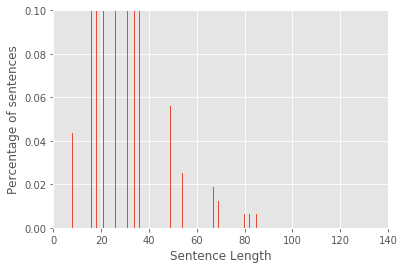

In [29]:
# TEST DATA - manually annotated
test_filename = r"C:\Users\20230326\1-2 OzROCK\Files\TestSet_March03.txt" # TestSet_March02

#test_data = pd.read_csv(filename, header = None, delimiter=" ", na_values=['\n'], quoting=csv.QUOTE_NONE, encoding='latin1', skip_blank_lines=True)
#print(test_data.info())
#print(test_data.head(10))
words = []
test_sentences = []
with open(test_filename, 'r') as file :
    currSentence = []
    lines = []
    for line in file:
        cols = line.split(" ")
        if line.strip() == '':
            # Reset sentence            
            test_sentences.append(currSentence)
            currSentence = []
        elif len(cols) > 2:
            print(line)
        else :
            currSentence.append([cols[0].strip(), cols[1].strip()])            
            words.append(cols[0].strip())
                
print(len(test_sentences)) # 18589; 160,343

test_words = list(set(words))
print('Num words in training + test sets = ', len(test_words))

test_sent_lengths = [len(s) for s in test_sentences]

plt.hist(test_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

In [3]:
# Word dictionary
words = train_words + test_words
words = list(set(words))
words.append("ENDPAD")

n_words = len(words) # unique words
print("Number of unique words in all data: ", n_words)

tags = list(set(tags))
n_tags = len(tags)
print("\nNumber of unique tags: ", n_tags)
print(tags)

print(len(words))
print(words[:10])

Number of unique words in all data:  44865

Number of unique tags:  13
['I-TIMESCALE', 'I-LOCATION', 'O', 'I-STRAT', 'I-MINERAL', 'I-ORE_DEPOSIT', 'B-TIMESCALE', 'B-LOCATION', 'B-STRAT', 'I-ROCK', 'B-ORE_DEPOSIT', 'B-MINERAL', 'B-ROCK']
44865
['barnes', 'prohibited', 'decimeter', 'cokey', '2117', '15.00', 'tlsr', 'forrestonia', 'commodity(s', 'indigofera']


To encode the character-level information, we will use character embeddings and a LSTM to encode every word to an vector.
We can use basically everything that produces a single vector for a sequence of characters that represent a word. You can also use a max-pooling architecture or a CNN or whatever works.
Then we feed the vector to another LSTM together with the learned word embedding.

In [4]:
# Create dictionaries of words and tags.
word2idx = {w: i + 4 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
word2idx["null"] = 2
word2idx["nan"] = 3

idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

print(word2idx["gold"]) # id=3818
print(tag2idx["B-ROCK"]) # id = 9

21298
13


In [5]:
print(word2idx["null"]) # id=3818

2


In [6]:
max_len = 80 # length of each sentence

#print(sentences[1])
print('Num words = ', len(word2idx))

X_word = [[word2idx[w[0]] for w in s] for s in train_sentences]
#X_word = []
#for s in sentences:
#    for w in s:
#        try:
#            a = [word2idx[w[0]] for w in s]
#            X_word.append(a)
#        except KeyError as err:
#            print('\nException: ', sys.exc_info()[0], err, '\n',
#                  s, '\n', w, a)
#print(X_word[0:10])

Num words =  44868


In [7]:
# Map the senctences to a sequence of numbers and then pad the sequence
# we increased the index of the words by one to use zero as a padding value.
# This is done because we want to use the mask_zeor parameter of the embedding layer to ignore inputs with value zero
from keras.preprocessing.sequence import pad_sequences

# Pad the sentences
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

Using TensorFlow backend.
C:\Users\20230326\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\20230326\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\20230326\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [8]:
# Generate a dictionary for the characters we want to use and create the sequence of characters for every token,
# set to 10.
# We could also use longer or shorter sequences. 
# We could even use two sequences, one with the five first characters and one with the five last chars
max_len_char = 30 # character length
print(max_len_char)

# tags = list(set(data["Tag"].values))
#chars = set([w_i for w in words for w_i in w])
#n_chars = len(chars)
#print(n_chars)
#print(chars)

import string
chars = [s for s in string.printable]
n_chars = len(chars)
print(n_chars)

30
100


In [9]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["PAD"] = 0
char2idx["UNK"] = 1
len(char2idx)

102

In [10]:
X_char = []
for sentence in train_sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [11]:
# Map tags to a sequence numbers and the pad
y = [[tag2idx[w[1]] for w in s] for s in train_sentences]
print(y[0])

y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')
print(y[0])

[3, 3, 12, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[ 3  3 12  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  8  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  0  0  0]


In [12]:
print(len(X_char[5]))
print(X_char[5].shape)
print(X_char[5][:2])

80
(80, 30)
[[65  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [70  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]]


In [13]:
# We split in train and test set.
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=44)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=44)

In [14]:
print(X_word_tr.shape)
print(X_word_te.shape)

print(len(X_char_tr))
print(len(X_char_te))

print(len(y_tr))
print(len(y_te))

(61458, 80)
(6829, 80)
61458
6829
61458
6829


Define the character embedding model
Trick is to wrap the parts that should be applied to the characters in a TimeDistributed layer to apply the same layers to every character sequence.

In [15]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 4, output_dim=64, input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=30, input_length=max_len_char, mask_zero=True))(char_in)

# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=100, return_sequences=False, recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)

main_lstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5))(x)

main_dense = TimeDistributed(Dense(100, activation="relu"))(main_lstm)  # a dense layer as suggested by neuralNer

out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_dense)

model = Model([word_in, char_in], out)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
# Train the model: compile the model and look at the summary.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [17]:
model.summary()
plot_model(model, to_file='model2_WL_CL_BiLSTM.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 30)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 80, 30, 30)   3060        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 64)       2871616     input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [18]:
#history = model.fit([X_word_tr,
#                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                    batch_size=32, epochs=100, validation_split=0.1, verbose=1)
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 55312 samples, validate on 6146 samples
Epoch 1/10
 - 1919s - loss: 0.1347 - val_loss: 0.0270
Epoch 2/10
 - 2419s - loss: 0.0209 - val_loss: 0.0140
Epoch 3/10
 - 2259s - loss: 0.0125 - val_loss: 0.0111
Epoch 4/10
 - 2275s - loss: 0.0088 - val_loss: 0.0100
Epoch 5/10
 - 2277s - loss: 0.0066 - val_loss: 0.0087
Epoch 6/10
 - 1616s - loss: 0.0050 - val_loss: 0.0086
Epoch 7/10
 - 1537s - loss: 0.0041 - val_loss: 0.0094
Epoch 8/10
 - 1513s - loss: 0.0033 - val_loss: 0.0082
Epoch 9/10
 - 1531s - loss: 0.0027 - val_loss: 0.0083
Epoch 10/10
 - 1511s - loss: 0.0023 - val_loss: 0.0076


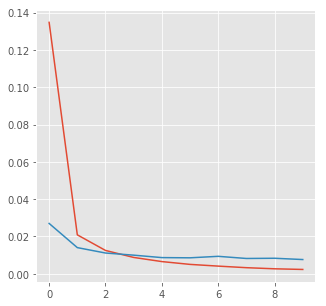

In [19]:
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

#plt.figure(figsize=(5,5))
#plt.plot(hist["sparse_categorical_accuracy"])
#plt.plot(hist["val_sparse_categorical_accuracy"])
plt.show()

In [20]:
# Save the model
from keras.models import load_model

model.save(r"C:/Users/20230326/wamex/data/2020_model_WL_CL_BiLSTM_Medium.h5")  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

In [21]:
# TEST this
# returns a compiled model, identical to the previous one
model_loaded = load_model(r"C:/Users/20230326/wamex/data/2020_model_WL_CL_BiLSTM_Medium.h5")
y_pred = model_loaded.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])
len(y_pred)

6829

In [22]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])
len(y_pred)

6829

In [23]:
def print_prediction(i):
    p = np.argmax(y_pred[i], axis=-1)
    print("{:15}|{:12}|{}".format("Word", "Dictionary", "Predicted"))
    print(40 * "=")

    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            print("{:15} {:12} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))        

In [24]:
len(y_pred) # Number of sentences in prediction / test set

def get_results(i):
    words_value = []
    tags_true = []
    tags_pred = []
    p = np.argmax(y_pred[i], axis=-1)
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")

    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
            words_value.append(idx2word[w])
            tags_true.append(idx2tag[t])
            tags_pred.append(idx2tag[pred])
            
    return words_value, tags_true, tags_pred

In [25]:
#for i in range(0, len(y_pred)):
words_tagged = []
labels_true = []
labels_predicted = []

for i in range(0, len(y_pred)):
    words_value, tags_true, tags_pred = get_results(i)
    words_tagged.extend(words_value)
    labels_true.extend(tags_true)
    labels_predicted.extend(tags_pred)

In [26]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

print(len(labels_true))
#print(y_te[0])

print(len(labels_predicted))
#print(y_pred[0])

#print(classification_report(labels_true, labels_predicted))
print(classification_report(labels_true, labels_predicted, digits=4))

189427
189427
             precision    recall  f1-score   support

      STRAT     0.9508    0.9807    0.9656       986
       ROCK     0.9870    0.9890    0.9880      4902
    MINERAL     0.9967    0.9941    0.9954      4934
   LOCATION     0.9906    0.9944    0.9925      4138
ORE_DEPOSIT     0.9700    0.9964    0.9830       552
  TIMESCALE     1.0000    0.9982    0.9991       544

  micro avg     0.9885    0.9920    0.9902     16056
  macro avg     0.9886    0.9920    0.9903     16056



In [27]:
print(labels_true[:20])
print(labels_predicted[:20])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STRAT', 'I-STRAT', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STRAT', 'I-STRAT', 'O', 'O']


# TEST SET
## Manually annotated dataset for model evaluation

In [30]:
# Get the word ids for each sentence
test_X_word = [[word2idx[w[0]] for w in s] for s in test_sentences]

# Pad the sentences
test_X_word = pad_sequences(maxlen=max_len, sequences=test_X_word, value=word2idx["PAD"], padding='post', truncating='post')

test_X_char = []
for sentence in test_sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    test_X_char.append(np.array(sent_seq))
    
# Map tags to a sequence numbers and the pad
test_y = [[tag2idx[w[1]] for w in s] for s in test_sentences]
print(y[0])

test_y = pad_sequences(maxlen=max_len, sequences=test_y, value=tag2idx["PAD"], padding='post', truncating='post')
print(test_y[0])

print('Test set word shape = ', test_X_word.shape)
print('Test set character length = ', len(test_X_char))
print('Test set labels length = ', len(test_y))

[ 3  3 12  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  8  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  0  0  0]
[3 3 3 3 3 9 4 4 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Test set word shape =  (1799, 80)
Test set character length =  1799
Test set labels length =  1799


In [31]:
# Predict the labels on the manually created TEST SET
test_y_pred = model.predict([test_X_word, np.array(test_X_char).reshape((len(test_X_char), max_len, max_len_char))])
len(test_y_pred) # Number of sentences in prediction / test set

def get_test_results(i):
    words_value = []
    tags_true = []
    tags_pred = []
    p = np.argmax(test_y_pred[i], axis=-1)
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")

    for w, t, pred in zip(test_X_word[i], test_y[i], p):
        if w != 0:
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
            words_value.append(idx2word[w])
            tags_true.append(idx2tag[t])
            tags_pred.append(idx2tag[pred])
            
    return words_value, tags_true, tags_pred

words_tagged = []
labels_true = []
labels_predicted = []

for i in range(0, len(test_y_pred)):
    words_value, tags_true, tags_pred = get_test_results(i)
    words_tagged.extend(words_value)
    labels_true.extend(tags_true)
    labels_predicted.extend(tags_pred)
    
print(len(labels_true))
#print(y_te[0])

print(len(labels_predicted))
#print(y_pred[0])

#print(classification_report(labels_true, labels_predicted))
print(classification_report(labels_true, labels_predicted, digits=4))

48033
48033
             precision    recall  f1-score   support

      STRAT     0.3475    0.0663    0.1114       618
       ROCK     0.5934    0.5632    0.5779      1495
ORE_DEPOSIT     0.7476    0.5548    0.6369       283
    MINERAL     0.6754    0.7430    0.7076       969
   LOCATION     0.0000    0.0000    0.0000       887
  TIMESCALE     1.0000    0.0051    0.0102       196

  micro avg     0.6136    0.3959    0.4813      4448
  macro avg     0.4865    0.3959    0.4048      4448

